In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cleaned/Training/Pituitary/image1_80.png
/kaggle/input/cleaned/Training/Pituitary/image1_930.png
/kaggle/input/cleaned/Training/Pituitary/image1_369.png
/kaggle/input/cleaned/Training/Pituitary/image1_39.png
/kaggle/input/cleaned/Training/Pituitary/image1_717.png
/kaggle/input/cleaned/Training/Pituitary/image1_622.png
/kaggle/input/cleaned/Training/Pituitary/image1_343.png
/kaggle/input/cleaned/Training/Pituitary/image1_891.png
/kaggle/input/cleaned/Training/Pituitary/image1_734.png
/kaggle/input/cleaned/Training/Pituitary/image1_738.png
/kaggle/input/cleaned/Training/Pituitary/image1_149.png
/kaggle/input/cleaned/Training/Pituitary/image1_526.png
/kaggle/input/cleaned/Training/Pituitary/image1_404.png
/kaggle/input/cleaned/Training/Pituitary/image1_111.png
/kaggle/input/cleaned/Training/Pituitary/image1_47.png
/kaggle/input/cleaned/Training/Pituitary/image1_162.png
/kaggle/input/cleaned/Training/Pituitary/image1_745.png
/kaggle/input/cleaned/Training/Pituitary/image1_763

# Importing necessary libraries

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, AUC,Recall
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.utils import image_dataset_from_directory

In [64]:
train_dir = '/kaggle/input/cleaned/Training/'
test_dir = '/kaggle/input/cleaned/Testing/'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [65]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Visualizing class distribution

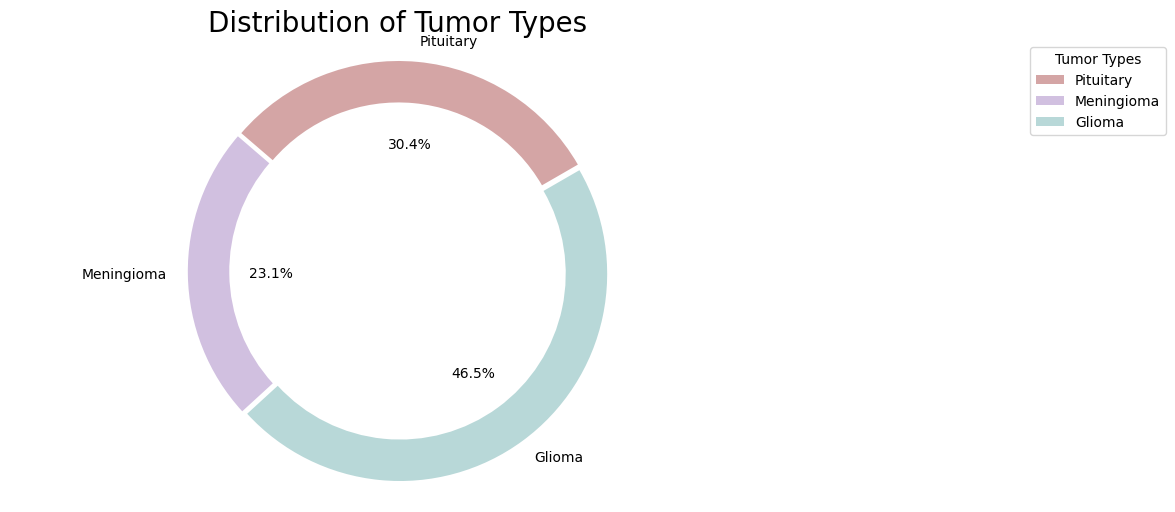

In [66]:
import matplotlib.pyplot as plt

# Data
labels = ['Pituitary', 'Meningioma', 'Glioma']
sizes = [
    len([x for x in train_labels if x == 'Pituitary']),
    len([x for x in train_labels if x == 'Meningioma']),
    len([x for x in train_labels if x == 'Glioma'])
]

# Custom color palette for a brain tumor vibe
colors = ['#D4A5A5', '#D1C0E0', '#B8D8D8']
explode = (0.015, 0.015, 0.015)

# Plotting
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%.1f%%', explode=explode, startangle=30, wedgeprops=dict(width=0.2))

# Title
plt.title('Distribution of Tumor Types', fontsize=20)

# Add a legend
plt.legend(labels, title='Tumor Types', loc='upper right', bbox_to_anchor=(1, 0, 0.5, 1))

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot
plt.show()

# Distribution of Data between Train and Test Sets

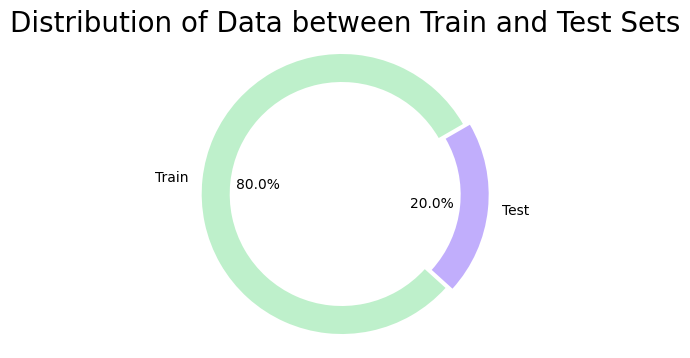

In [67]:
import matplotlib.pyplot as plt

# Data
labels = ['Train', 'Test']
sizes = [len(train_labels), len(test_labels)]
colors = ['#BEF0CB', '#C1AEFC']
explode = (0.05, 0)

# Plotting
plt.figure(figsize=(6, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%.1f%%', explode=explode, startangle=30, wedgeprops=dict(width=0.2))

# Title
plt.title('Distribution of Data between Train and Test Sets', fontsize=20)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')


# Show the plot
plt.show()


# Count of each class

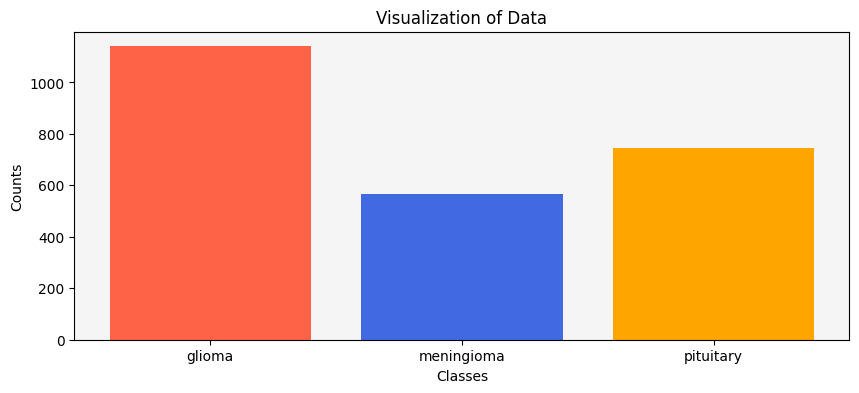

In [68]:
plt.figure(figsize=(10,4))
colors = ['#FF6347',  # Red for glioma
          '#4169E1',  # Blue for meningioma
          '#FFA500']  # Orange for pituitary
plt.bar(['glioma','meningioma','pituitary'],[1140,566,744],color=colors)

plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Visualization of Data')
plt.gca().set_facecolor('#F5F5F5')
plt.show()

In [69]:
def train_df(tr_path):
    classes = []
    class_paths = []
    files = os.listdir(tr_path)
    for file in files:
        label_dir = os.path.join(tr_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [70]:
def test_df(ts_path):
    classes = []
    class_paths = []
    files = os.listdir(ts_path)
    for file in files:
        label_dir = os.path.join(ts_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    ts_df = pd.concat([image_paths, image_classes], axis=1)
    return ts_df

In [71]:
tr_df = train_df('/kaggle/input/cleaned/Training')

In [72]:
ts_df = test_df('/kaggle/input/cleaned/Testing')

In [73]:
tr_df.shape+ts_df.shape

(2450, 2, 614, 2)

# Creating validation dataset

In [74]:
train_df,valid_df = train_test_split(tr_df, train_size=.8, random_state=20)

# Data generators for Image Augmentation

In [75]:
image_size = (256, 256)

# Training batch size
batch_size = 32

SEED=1345

train_datagen=ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")
validation_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)


tr_gen = train_datagen.flow_from_dataframe(train_df, x_col='Class Path',
                                 y_col='Class',
                                 target_size=image_size,seed = SEED,
                                 batch_size=32,
                                 class_mode ='categorical',)

valid_gen = validation_datagen.flow_from_dataframe(valid_df, x_col='Class Path',
                                    y_col='Class',
                                    target_size=image_size,seed = SEED,
                                    batch_size=64,
                                    class_mode ='categorical',)

ts_gen = test_datagen.flow_from_dataframe(ts_df, x_col='Class Path',
                                y_col='Class',
                                 target_size=image_size,shuffle=False,
                                 seed = SEED,
                                 batch_size=32,
                                 class_mode ='categorical',)

Found 1960 validated image filenames belonging to 3 classes.
Found 490 validated image filenames belonging to 3 classes.
Found 614 validated image filenames belonging to 3 classes.


# Visualizing Data

In [76]:
class_names=list(tr_gen.class_indices.keys())

In [77]:
class_names

['Glioma', 'Meningioma', 'Pituitary']

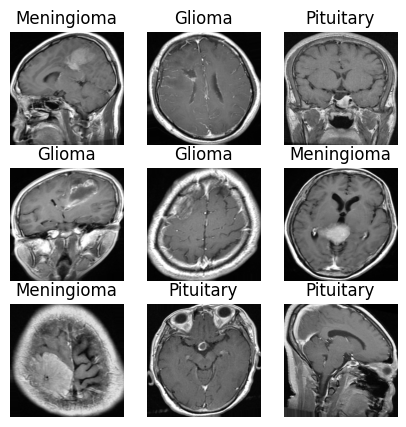

In [78]:
plt.figure(figsize=(5, 5))
for images, labels in tr_gen:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break

# Model Creation VGG19

In [79]:
image_size = (256,256,3)


class_count = len(list(tr_gen.class_indices.keys()))
model = Sequential([
    
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_size),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
#     Dropout(0.5, seed=SEED),
    Dense(class_count, activation="softmax")
])


In [80]:
input_shape = (256, 256, 3)

# Create an instance of the VGG19 model

train_features = model.predict(tr_gen, steps=len(tr_gen), verbose=1)
val_features=model.predict(valid_gen,len(valid_gen),verbose=1)
test_features = model.predict(ts_gen, steps=len(ts_gen), verbose=1)

20/20 [==============================] - 3s 125ms/step


In [81]:
train_labels=tr_gen.classes
val_labels=valid_gen.classes
test_label=ts_gen.classes

In [82]:
trainval_features = np.concatenate((train_features, val_features))
trainval_labels = np.concatenate((train_labels, val_labels))

In [83]:
X_train_2d = trainval_features.reshape(trainval_features.shape[0], -1)

In [84]:
X_test_2d = test_features.reshape(test_features.shape[0], -1)

# PCA

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
pca = PCA()

In [86]:
X_pca = pca.fit_transform(X_train_2d)

In [87]:
#Determine the number of components
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

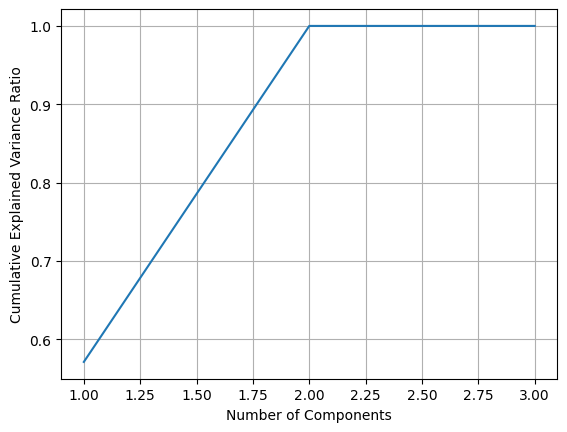

In [88]:
# Plot the cumulative explained variance ratio
import matplotlib.pyplot as plt
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [89]:
# Choose the number of components that capture a significant portion of variance (90%)
n_components = np.argmax(cumulative_explained_variance_ratio >= 0.9) + 1
selected_features = X_pca[:, :n_components]

In [90]:
selected_features.shape

(2450, 2)

In [91]:
X_train=selected_features

In [92]:
indices = np.random.permutation(2450)

# Shuffle X_train and X_labels using the same indices
shuffled_X_train = X_train[indices]
shuffled_X_labels = trainval_labels[indices]

In [93]:
indices

array([2071,  995, 1049, ..., 1625, 1754,  171])

# XGB

In [94]:
import xgboost as xgb
xgb = xgb.XGBClassifier(n_estimators=150,max_depth=5,learning_rate=0.01)
xgb.fit(shuffled_X_train, shuffled_X_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [95]:
X_test=pca.transform(X_test_2d)
X_test=X_test[:, :n_components]
xgb.score(X_test,test_label)

0.44299674267100975

In [96]:
from sklearn.metrics import confusion_matrix, classification_report
# Make predictions on the test data
y_pred = xgb.predict(X_test)

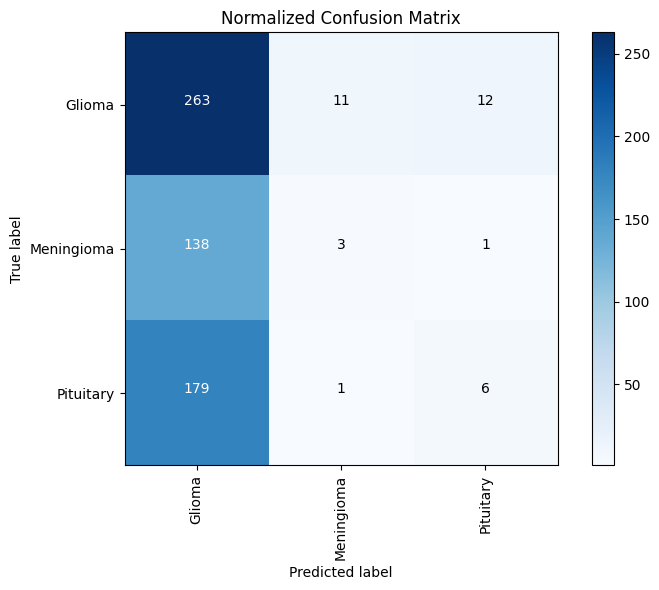

In [97]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized Confusion Matrix"
    else:
        title = "Confusion Matrix"

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
#     '.2f' if normalize else 
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_label, y_pred)

class_names

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, class_names, normalize=True)
plt.show()

In [98]:
# Compute the classification report
report = classification_report(test_label, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.92      0.61       286
           1       0.20      0.02      0.04       142
           2       0.32      0.03      0.06       186

    accuracy                           0.44       614
   macro avg       0.32      0.32      0.23       614
weighted avg       0.35      0.44      0.31       614



# GaussianNaiveBayes

In [99]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(shuffled_X_train, shuffled_X_labels)

GaussianNB()

In [100]:
gnb.score(X_test,test_label)

0.46579804560260585

In [101]:
y_pred = gnb.predict(X_test)

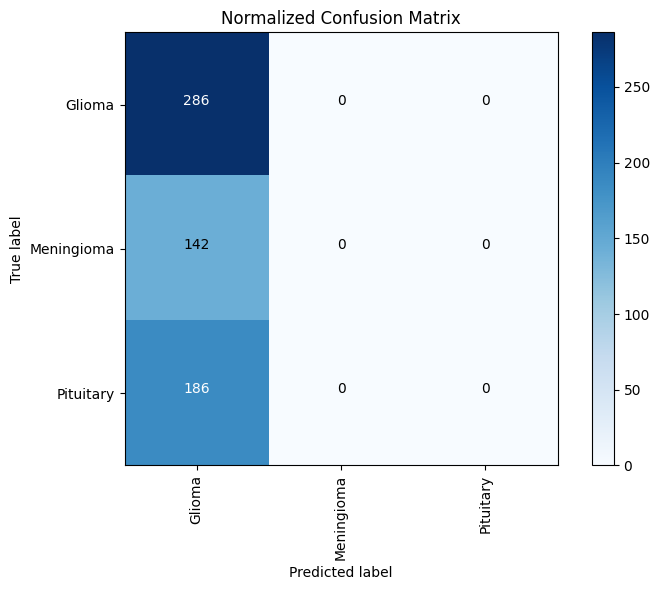

In [102]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized Confusion Matrix"
    else:
        title = "Confusion Matrix"

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
#     '.2f' if normalize else 
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_label, y_pred)

class_names

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, class_names, normalize=True)
plt.show()

In [103]:
# Compute the classification report
report = classification_report(test_label, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       286
           1       0.00      0.00      0.00       142
           2       0.00      0.00      0.00       186

    accuracy                           0.47       614
   macro avg       0.16      0.33      0.21       614
weighted avg       0.22      0.47      0.30       614



# SVC

In [104]:
from sklearn.svm import SVC

In [105]:
svc = SVC()
svc.fit(shuffled_X_train, shuffled_X_labels)

SVC()

In [106]:
svc.score(X_test,test_label)

0.46579804560260585

In [107]:
y_pred = svc.predict(X_test)

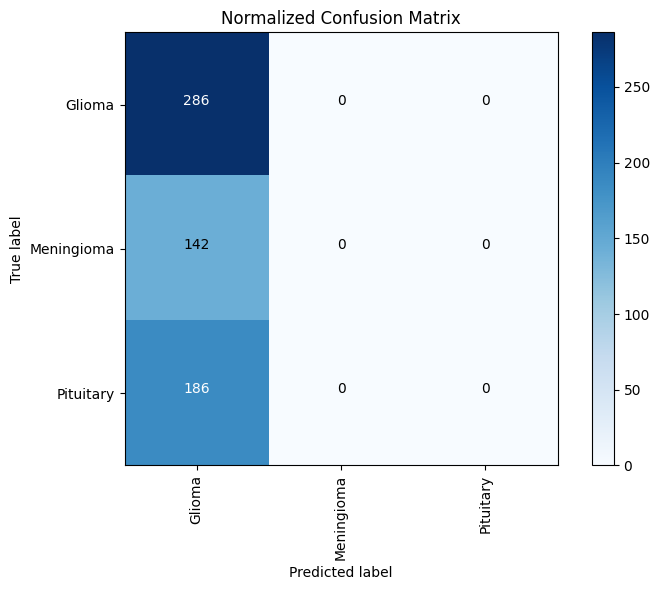

In [108]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized Confusion Matrix"
    else:
        title = "Confusion Matrix"

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
#     '.2f' if normalize else 
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_label, y_pred)

class_names

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, class_names, normalize=True)
plt.show()

In [109]:
# Compute the classification report
report = classification_report(test_label, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       286
           1       0.00      0.00      0.00       142
           2       0.00      0.00      0.00       186

    accuracy                           0.47       614
   macro avg       0.16      0.33      0.21       614
weighted avg       0.22      0.47      0.30       614



# Random Forest Classifier

In [110]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

In [111]:
grid_space={'max_depth':[3,5,10,None],
              'n_estimators':[10,100,200],
              'max_features':[1,3,5,7],
              'min_samples_leaf':[1,2,3],
              'min_samples_split':[1,2,3]
           }

In [112]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(rf,param_grid=grid_space,cv=3,scoring='accuracy')
model_grid = grid.fit(shuffled_X_train, shuffled_X_labels)

In [113]:
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Best hyperparameters are: {'max_depth': 3, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
Best score is: 0.46408228734170126


In [114]:
y_pred = svc.predict(X_test)

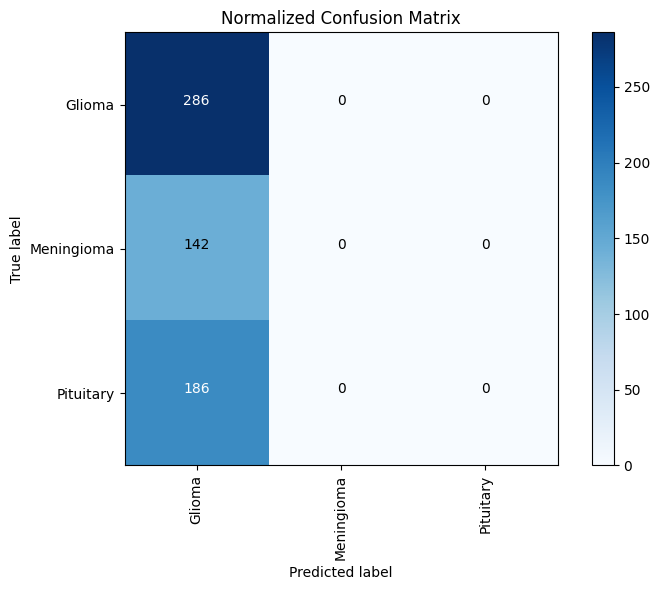

In [115]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized Confusion Matrix"
    else:
        title = "Confusion Matrix"

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
#     '.2f' if normalize else 
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_label, y_pred)

class_names

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, class_names, normalize=True)
plt.show()

In [116]:
# Compute the classification report
report = classification_report(test_label, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       286
           1       0.00      0.00      0.00       142
           2       0.00      0.00      0.00       186

    accuracy                           0.47       614
   macro avg       0.16      0.33      0.21       614
weighted avg       0.22      0.47      0.30       614

